In [1]:
#!/usr/bin/env python
# coding: utf-8

# In[1]:



import numpy as np 
import pandas as pd 
import warnings 
warnings.filterwarnings("ignore")
import tensorflow as tf 


print(tf.__version__)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Bidirectional
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras import Input
from tensorflow.keras.layers import Flatten, Reshape
from tensorflow.keras import Model
from tensorflow.keras.layers import Conv2D,concatenate
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout
from attention import Attention_Block
# from attention import attention_block
from tensorflow.keras.layers import Attention
from step_attention import AttentionAugmentation2D, _normalize_depth_vars
# from keras.models import load_model

# In[2]:


# from google.colab import drive
# drive.mount('/content/drive')



# In[3]:


from loss import discounted_l1, max_displacement_error,v3_displacement_error
import math
import pickle5 as pickle
import matplotlib.pyplot as plt
from numpy import array
# import horovod.tensorflow.keras as hvd

2.2.0


In [2]:

# hvd.init()

# In[4]:

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="1"


gpus = tf.config.experimental.list_logical_devices('GPU')
print(gpus)


if gpus:
    
    try:
        
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu,True)
    except:
        print('checking gpu error')
print('checking GPUs')


from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config=tf.compat.v1.ConfigProto()
# config.gpu_options.visible_device_list= '0,1'
config.gpu_options.allow_growth=True

config.log_device_placement=True
# config.visible_device_list =2
sess=tf.compat.v1.Session(config=config)

tf.compat.v1.keras.backend.set_session(sess)


# In[5]:


from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras import initializers
import tensorflow.keras.backend as K
from sklearn.model_selection import train_test_split

from load_data import load_data
import os

[LogicalDevice(name='/device:GPU:0', device_type='GPU')]
checking gpu error
checking GPUs
Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: TITAN X (Pascal), pci bus id: 0000:06:00.0, compute capability: 6.1



In [3]:

from pathlib import Path
home = str(Path.home())





In [4]:

# In[9]:


filters=20
kernel_size = (3,3)
strides = (1,1)
depth_k =0.2
depth_v =0.2

channel_axis = 1 if K.image_data_format() == 'channels_first' else -1
print("before normalized k, v",depth_k,depth_k,strides)
depth_k, depth_v = _normalize_depth_vars(depth_k, depth_v, filters)
print("after normalized k, v",depth_k,depth_k,strides)


# In[10]:
time_step=10
tf.compat.v1.disable_eager_execution()

rnn = Sequential()
rnn.add(LSTM(128, return_sequences=True, kernel_regularizer='l1', input_shape=(time_step,2)))
rnn.add(LSTM(256, return_sequences=True, kernel_regularizer='l1',input_shape=(time_step,128)))
rnn.add(Reshape((time_step,16,16,1)))
rnn.summary()



cnn = Sequential()

cnn.add(Conv2D(1024, (4, 4),input_shape=(16, 16, 1)))
cnn.add(Conv2D(512, (2, 2)))
cnn.add(Conv2D(256, (4, 4)))
cnn.add(Conv2D(128, (2, 2)))
cnn.add(MaxPooling2D(2,2))
cnn.add(Conv2D(64, (2, 2)))
cnn.add(Conv2D(32, (2, 2)))
cnn.add(Conv2D(16, (2, 2)))

#attention block below
cnn.add(Conv2D(2 * depth_k + depth_k, (1, 1), strides))
cnn.add(AttentionAugmentation2D(depth_k, depth_v, num_heads=4, relative=True))

# cnn.add(Dropout(0.5))
cnn.add(Flatten())

 
cnn.add(Dense(128))
cnn.add(Dense(32))

cnn.summary() 



rnn2=Sequential()
rnn2.add(GRU(256, input_shape=(time_step,32)))


dense = Sequential()
dense.add(Dense(128))
dense.add(Dense(64))
dense.add(Dense(2)) # Model output

main_input = Input(shape=(time_step,2)) 
model = rnn(main_input)
model = TimeDistributed(cnn)(model) 
 # combine timedistributed cnn, attention, and fully connected network with rnn
model = rnn2(model)
model = dense(model) # add dense
final_model = Model(inputs=main_input, outputs=model)
final_model.summary()


before normalized k, v 0.2 0.2 (1, 1)
after normalized k, v 4 4 (1, 1)
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 10, 128)           67072     
_________________________________________________________________
lstm_1 (LSTM)                (None, 10, 256)           394240    
_________________________________________________________________
reshape (Reshape)            (None, 10, 16, 16, 1)     0         
Total params: 461,312
Trainable params: 461,312
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 13, 13, 1024)      17408     
________

In [5]:


n_batch = 32

n_epoch  = 150


# checkpoint_path =home+ "/repo/models/lyft_cyc2_{epoch}.h5"
# checkpoint_dir = os.path.dirname(checkpoint_path)


# Create a callback that saves the model's weights
# cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
#                                                  save_weights_only=True,
#                                                  verbose=1)


 #(None, n_steps, n_features)

sgd = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.5, nesterov=True)
rmsprop =tf.keras.optimizers.RMSprop(learning_rate=0.001)



ftrl = tf.keras.optimizers.Ftrl(learning_rate=0.01)


mtrc = [tf.keras.metrics.MeanAbsoluteError()]
# [tf.keras.metrics.CosineSimilarity(axis=1)]

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.1,
    decay_steps=10000,
    decay_rate=0.95)

adagrad = tf.keras.optimizers.Adagrad(learning_rate=lr_schedule)
adadelta = tf.keras.optimizers.Adadelta(learning_rate=lr_schedule)

# # to use customized loss, choose from  discounted_l1 or max_displacement_error function as loss parameter 
# final_model.compile(loss=v3_displacement_error, optimizer=adadelta, metrics=mtrc)
# # final_model.load_weights('/home/lab1/repo/models/lyft_cyclist/lyft_cyclist2_larger_1.h5')

# history=final_model.fit(X_train, 
#                         y_train, epochs=n_epoch, 
#                         batch_size=n_batch, 
#                         verbose=2, 
#                         validation_data=(X_val, y_val),
#                         callbacks=[cp_callback])





In [6]:
# print("Evaluate on test data")
# results = final_model.evaluate(X_test, y_test, batch_size=32)
# print("test loss, test acc:", results)


# _history_path = home+ '/repo/models/cyc2_history.sav'
# pickle.dump(history.history, open(_history_path, 'wb'))

# _weights_path =  home+ '/repo/models/cyc2_weights.h5'
# final_model.save_weights(_weights_path)


## Instructions

Three settings are defined below for three different agent types. Uncomment each agent type, and comment out other two types to run. For example, when want to plot the performance on cyclists, in the below cell, use the cyclists setting, and comment out veh/ped settings, and run the whole pipeline. When changing to ped, or veh, you will need to modify the setting below, and RE-RUN the whole pipeline, which will re-initialize the model and weights by cleanning all caches created by the previous run cyc model. 

In [7]:
final_model.compile(loss=v3_displacement_error, optimizer=adadelta, metrics=mtrc)

# cyclist settings
# X_test= np.load("train_data/c_xtest_all.npy")
# y_test = np.load("train_data/c_ytest_all.npy")
# all_y = np.load("train_data/c_y_all.npy") # y is the full gt trajectory of xtest, relative coordinate
# final_model.load_weights('cyc_models/cyc_Feb4.h5') # transfer learning from ped


# # ped settings
X_test= np.load("train_data/p_xtest_8kfb.npy")
y_test = np.load("train_data/p_ytest_8kfb.npy")
all_y = np.load("train_data/p_y_8kfb.npy") # y is the full gt trajectory of xtest, relative coordinate
final_model.load_weights('ped_models/ped_8kfb_Feb4.h5') # transfer learning from ped

# # veh settings
# X_test= np.load("train_data/v_xtest_8kfb.npy")
# y_test = np.load("train_data/v_ytest_8kfb.npy")
# all_y = np.load("train_data/v_y_8kfb.npy") # y is the full gt trajectory of xtest, relative coordinate
# final_model.load_weights('veh_models/veh_8kfb2.h5') # transfer learning from ped

In [8]:
# ### option : try 8kfb data 
# prefix ='/home/lab1/repo/planning/traj_pred/data/'
# train_raw, test_raw=None, None
# for i in range(1):
#     name_tr= prefix+'cyc_train_set_8kfb'+'.npy'
#     name_te= prefix+'cyc_test_set_8kfb'+'.npy'
#     tr = np.load(name_tr,allow_pickle=True).astype(float)
#     te = np.load(name_te,allow_pickle=True).astype(float)
#     if train_raw is None:
#         train_raw=tr
#     else:
#         train_raw= np.vstack((train_raw, tr))
    
#     if test_raw is None:
#         test_raw=te
#     else:
#         test_raw= np.vstack((test_raw, te))

# print(train_raw.shape, test_raw.shape)


# test_set = test_raw
# X_test=test_set[:,:10,2:4]
# y_test=test_set[:,10,2:4]
# all_y = test_set[:,10:,2:4]

# print(X_train.shape, y_train.shape, X_test.shape, y_test.shape, y.shape)


In [9]:
# final_model.compile(loss=v3_displacement_error, optimizer=adadelta, metrics=mtrc)

# final_model.load_weights('/home/lab1/repo/models/lyft_vehnew_150.h5')
# ground_truth = np.load("array/ground_truth_prediction_vehicle.npy",allow_pickle=True) # load data here
# samples = np.load("array/history_vehicle.npy",allow_pickle=True)

# final_model.load_weights('/home/lab1/repo/models/lyft_pednew_150.h5')
# ground_truth = np.load("array/ground_truth_prediction_pedestrian.npy",allow_pickle=True) # load data here
# samples = np.load("array/history_pedestrian.npy",allow_pickle=True)


# final_model.load_weights('/home/lab1/repo/models/lyft_cycnew005_150.h5')
# final_model.load_weights('cyc_models/cyc_model.h5') # transfer learning from ped
# final_model.load_weights('/home/lab1/repo/models/lyft_cyc_transferveh_150.h5') # transfer learning from veh

# test_set = np.load("train_data/v_test_xall.npy",allow_pickle=True)
# ground_truth = test_set[:,10:,2:4] # load data here
# samples =  test_set[:,:10,2:4]
# print(samples.shape, ground_truth.shape)

##prediction
# from utilities import get_position_sequence
def get_position_sequence(prev, new):
    arr = np.delete(prev, 0, 0)
    a=np.vstack((arr,new))
    return a 

def get_sequence_prediction(X_position_test, i):
    results =[]
    s=X_position_test[i]
    temp=s
    s=s-s[0]
    for count in range(0,10):
        
        result = final_model.predict(np.array([s]))
#         print(result)
        results.append(result[0])
        s = get_position_sequence(s, result)
    results=np.array(results)
#     print(s.shape,results.shape)
#     print(results)
#     print(temp)
    results+=temp
#     print(results)
    return results

# i= np.random.randint(0, len(X_test))
# results = get_sequence_prediction(X_test, i)
# print(results.shape)

# test=np.load('cyclist_test_history.npy')
# v_predict=[]
# print(len(test))
# for i in range(len(test)):
#     print(i)
#     results = get_sequence_prediction(test, i)
#     v_predict.append(results)


In [10]:


samples=X_test
ground_truth =all_y
# exception = set(exception.astype(float))
# samples= np.around(samples,decimals=6)
# ground_truth = np.around(ground_truth,decimals=6)
exception = set()

print(samples.shape, ground_truth.shape)

(955, 10, 2) (955, 10, 2)


In [11]:
final_results=[]
final_displacement=[]
avg_displacement=[]

for idx in range(0,len(samples)):
    if idx in exception: 
        print(idx) 
        continue
    if idx%100==0:print(idx)
    p=[]
    re= get_sequence_prediction(samples, idx)
    final_results.append(re)
#     print(re.shape, ground_truth[idx].shape)
#     print(re,ground_truth[idx] )
    distance = v3_displacement_error(re,ground_truth[idx] )
    avg = K.mean(distance)
    
    with tf.compat.v1.Session() as sess:
        p=distance.eval()
        ax =avg.eval()
#     print(p,ax)
    final_displacement.append(p)
    avg_displacement.append(ax)

final_displacement = np.array(final_displacement)
sec=[]

for j in range(0,final_displacement.shape[1]):
    displacement = sum(final_displacement[:,j])/len(final_displacement)
    
    sec.append(displacement)
print("Final displacement error:",sec[-1])
print("Average displacement error:",sum(avg_displacement)/len(avg_displacement))







0
100
200
300
400
500
600
700
800
900
Final displacement error: 6.101495778166707
Average displacement error: 2.773512062830654


[0.09496201273527241, 0.6037295900505543, 1.1324855379959176, 1.6776465622285632, 2.257999702732079, 2.8740177013802812, 3.5479944028684214, 4.29851799330443, 5.1462713468443155, 6.101495778166707]


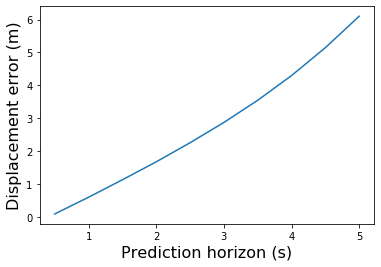

In [12]:
# np.save("model_cyc_ped",sec)
x_axis = np.arange(0.5,5.5, 0.5)
print(sec)
import matplotlib.pyplot as plt 
plt.plot(x_axis, sec)
plt.xlabel("Prediction horizon (s)", fontsize=16)
plt.ylabel("Displacement error (m)", fontsize=16)
plt.show()

In [ ]:
# Done